In [17]:
import sys

sys.path.append("../")

In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from datetime import datetime, timedelta
from arch.unitroot import PhillipsPerron
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

DATA_PATH = '/mnt/d/Trading/trading-agent/crypto-pair-trading/data/5min'

In [19]:
selected_pairs = ['ETH-USDT','BCH-USDT','XLM-USDT']

data = []
start_date = (datetime.utcnow() - timedelta(days=30)).strftime('%Y-%m-%d')

for symbol in selected_pairs:
    try:
        df = pd.read_csv(f'{DATA_PATH}/{symbol}.csv', 
                        parse_dates=['open_time'], 
                        index_col=['open_time'])

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        data.append(df[df.index > start_date][symbol])
    except:
        pass

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.tail()

,ETH-USDT,BCH-USDT,XLM-USDT
open_time,,,
2021-08-30 00:40:00,3206.72,655.5,0.3436
2021-08-30 00:45:00,3187.69,654.7,0.3424
2021-08-30 00:50:00,3188.74,653.8,0.3425
2021-08-30 00:55:00,3190.53,654.2,0.3426
2021-08-30 01:00:00,3190.47,654.6,0.3424


<AxesSubplot:xlabel='open_time'>

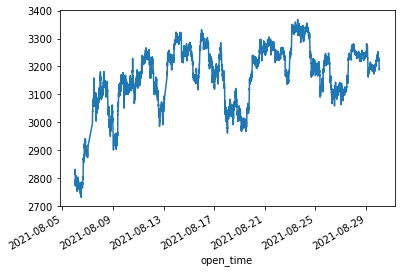

In [20]:
df['ETH-USDT'].plot()

<AxesSubplot:xlabel='open_time'>

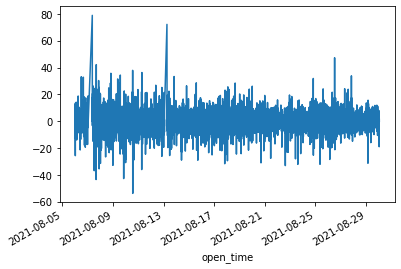

In [21]:
df['ETH-USDT'].diff().plot()

In [22]:
def adf_test(timeseries, verbose=False):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    if verbose:
        print ('Results of Dickey-Fuller Test:')
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    return dfoutput['p-value']

In [23]:
def pp_test(timeseries, verbose=False):
    pp = PhillipsPerron(timeseries)
    if verbose:
        print(pp.summary().as_text())
    
    return pp.pvalue


def kpss_test(timeseries, verbose=False):
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])

    if verbose:
        print ('Results of KPSS Test:')
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        print (kpss_output)
    return kpss_output['p-value']


In [24]:
methods = {
    'adf': adf_test,
    'pp': pp_test,
    'kpss': kpss_test
}


def perform_test(method, series):
    func_ = methods[method]
    
    # p_v1 = func_(np.log(series))
    p_v1 = func_(series)

    # diff = np.log(series) - np.log(series.shift(1))
    diff = series.diff()
    diff.dropna(inplace=True)
    p_v2 = func_(diff)

    return p_v1, p_v2

In [25]:
data = {
    'adf': [],
    'pp': [],
    'kpss': []
}
columns = []

for col in df.columns:
    for test in methods.keys():
        p1, p2 = perform_test(test, df[col])
        data[test].append(p1)
        data[test].append(p2)
    
    if col not in columns:
        columns.append(col)
    
    if f'd_{col}' not in columns:
        columns.append(f'd_{col}')

    

test_df = pd.DataFrame.from_dict(data, orient='index', columns=columns)
test_df.head()

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/home/bean/miniconda3/envs/t

,ETH-USDT,d_ETH-USDT,BCH-USDT,d_BCH-USDT,XLM-USDT,d_XLM-USDT
adf,0.008904,0.0,0.162033,2.185981e-30,0.180562,0.0
pp,0.008096,0.0,0.171879,0.000000e+00,0.188688,0.0
kpss,0.010000,0.1,0.010000,1.000000e-01,0.010000,0.1


The prices are not stationary but they all become stationary after the first differencing.
For both adf and pp for the first differencing, `p-value` < 0.05 so we can reject the null.
KPSS all 3 diff series is above the critical value so we can accept the null (series is stationary).

Therefore, we can conclude that ETH, BCH, XLM are `I(1)` processes.

which:
- I(0): trend stationary
- I(1): diference stationary


The Engle-Granger method involves a linear regression on given time series data which,
in this case, is BTC; but it is not important which cryptocurrency is taken as the dependent
variable. We propose the following OLS model:

$$
ETH_t = c + \beta_1 BCH_t + \beta_2 XLM_t + \epsilon_t
$$

In [26]:
renamed = {col: col.replace('-USDT', '') for col in df.columns}

df.rename(columns=renamed, inplace=True)

In [27]:
df = sm.add_constant(df)
df

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,ETH,BCH,XLM
open_time,,,,
2021-08-06 00:05:00,1.0,2817.61,544.83,0.28013
2021-08-06 00:10:00,1.0,2830.19,547.08,0.28055
2021-08-06 00:15:00,1.0,2831.24,548.09,0.28106
2021-08-06 00:20:00,1.0,2821.15,545.40,0.28071
2021-08-06 00:25:00,1.0,2813.59,544.50,0.27898
...,...,...,...,...
2021-08-30 00:40:00,1.0,3206.72,655.50,0.34360
2021-08-30 00:45:00,1.0,3187.69,654.70,0.34240
2021-08-30 00:50:00,1.0,3188.74,653.80,0.34250


In [31]:

model = sm.OLS.from_formula(formula='ETH ~ const + BCH + XLM', data=df)

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    ETH   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     4958.
Date:                Sun, 05 Sep 2021   Prob (F-statistic):               0.00
Time:                        20:38:13   Log-Likelihood:                -38880.
No. Observations:                6775   AIC:                         7.777e+04
Df Residuals:                    6772   BIC:                         7.779e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1017.6167      9.667    105.262      0.0

From above Table, we obtain the relationships:

$$
ETH = 1017.6167 + 0.66BCH + 2036.83XLM + \epsilon_t
$$

Notably, all the regressing coefficients appear to be statistically significant with p-values less than 1%.
R-squared: 59.4%.

In [32]:
results.resid.head()

open_time
2021-08-06 00:05:00   -150.921218
2021-08-06 00:10:00   -140.694624
2021-08-06 00:15:00   -141.355815
2021-08-06 00:20:00   -148.942057
2021-08-06 00:25:00   -152.379165
dtype: float64

In [33]:
results.params

Intercept    1017.616670
const        1017.616670
BCH             0.665750
XLM          2036.831303
dtype: float64

In [36]:
adf_test(results.resid, verbose=True)

Results of Dickey-Fuller Test:
Test Statistic                   -3.456381
p-value                           0.009181
#Lags Used                       13.000000
Number of Observations Used    6761.000000
Critical Value (1%)              -3.431318
Critical Value (5%)              -2.861968
Critical Value (10%)             -2.566998
dtype: float64


0.0091805963826641

In [39]:
pp_test(results.resid, verbose=True)

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.322
P-value                         0.014
Lags                               35
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


0.013904345666051346

In [40]:
kpss_test(results.resid, verbose=True)

Results of KPSS Test:
Test Statistic            0.835494
p-value                   0.010000
Lags Used                52.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


0.01